In [0]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.config('spark.driver.maxResultSize', '18g').getOrCreate()

In [0]:
from pyspark.sql.functions import lit,col
import pyspark.sql.functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import *

In [0]:
path = "dbfs:/mnt/lsde/group05/comment_position_3class/2014-10.parquet"

In [0]:
df = spark.read.load(path,format ="parquet")

In [0]:
df.show()

+---------+-------+------+-----------+
parent_id| id|result|created_utc|
+---------+-------+------+-----------+
t3_2jmrm1|cld4khd| [2.0]| 1413662424|
t3_2jmscs|cld4ksy| [2.0]| 1413662445|
t3_2jmrm1|cld4lp6| [2.0]| 1413662500|
t3_2jlx1y|cld4q53| [2.0]| 1413662784|
t3_2jmsvt|cld4ski| [2.0]| 1413662931|
t3_2jmt8v|cld4taw| [0.0]| 1413662980|
t3_2jmt8v|cld4yem| [2.0]| 1413663293|
t3_2jmtot|cld4yvf| [2.0]| 1413663321|
t3_2jmtva|cld4zkz| [2.0]| 1413663368|
t3_2jljxk|cld5028| [2.0]| 1413663397|
t3_2jljxk|cld50p3| [2.0]| 1413663438|
t3_2jlzhg|cld5136| [0.0]| 1413663461|
t3_2jljxk|cld52kx| [1.0]| 1413663555|
t3_2jmtot|cld53ep| [2.0]| 1413663607|
t3_2jmtot|cld53fn| [2.0]| 1413663609|
t3_2jmtva|cld56zo| [2.0]| 1413663829|
t3_2jlppf|cld59gd| [2.0]| 1413663985|
t3_2jj1w5|cld59ia| [2.0]| 1413663990|
t3_2jmtot|cld5b06| [2.0]| 1413664086|
t3_2jmtot|cld5cbk| [2.0]| 1413664169|
+---------+-------+------+-----------+
only showing top 20 rows

In [0]:
#0 for Ukraine 1 for Russia
def judgeAff(lst):
    aff=lst[0]
    if int(float(aff))==1:
        return 1
    elif int(float(aff))==2:
        return 2
    else:
        return 0

In [0]:
judgeAff_f = udf(judgeAff, IntegerType())
spark.udf.register(name="judgeAff_f", f=judgeAff_f)

Out[7]: <function __main__.judgeAff(lst)>

In [0]:
df =df.withColumn("aff",judgeAff_f('result'))

In [0]:
df.show()

+---------+-------+------+-----------+---+
parent_id| id|result|created_utc|aff|
+---------+-------+------+-----------+---+
t3_2jmrm1|cld4khd| [2.0]| 1413662424| 2|
t3_2jmscs|cld4ksy| [2.0]| 1413662445| 2|
t3_2jmrm1|cld4lp6| [2.0]| 1413662500| 2|
t3_2jlx1y|cld4q53| [2.0]| 1413662784| 2|
t3_2jmsvt|cld4ski| [2.0]| 1413662931| 2|
t3_2jmt8v|cld4taw| [0.0]| 1413662980| 0|
t3_2jmt8v|cld4yem| [2.0]| 1413663293| 2|
t3_2jmtot|cld4yvf| [2.0]| 1413663321| 2|
t3_2jmtva|cld4zkz| [2.0]| 1413663368| 2|
t3_2jljxk|cld5028| [2.0]| 1413663397| 2|
t3_2jljxk|cld50p3| [2.0]| 1413663438| 2|
t3_2jlzhg|cld5136| [0.0]| 1413663461| 0|
t3_2jljxk|cld52kx| [1.0]| 1413663555| 1|
t3_2jmtot|cld53ep| [2.0]| 1413663607| 2|
t3_2jmtot|cld53fn| [2.0]| 1413663609| 2|
t3_2jmtva|cld56zo| [2.0]| 1413663829| 2|
t3_2jlppf|cld59gd| [2.0]| 1413663985| 2|
t3_2jj1w5|cld59ia| [2.0]| 1413663990| 2|
t3_2jmtot|cld5b06| [2.0]| 1413664086| 2|
t3_2jmtot|cld5cbk| [2.0]| 1413664169| 2|
+---------+-------+------+-----------+---+
only showing top 20 rows

In [0]:
aff_group = df.groupBy('aff').agg(F.count('id').alias('affcount')).withColumn('date',lit('2014-10'))

In [0]:
aff_group.show()

+---+--------+-------+
aff|affcount| date|
+---+--------+-------+
 1| 1420|2014-10|
 2| 15788|2014-10|
 0| 2478|2014-10|
+---+--------+-------+

In [0]:
def handle(year_range = [2015, 2016, 2017], month_range = range(1, 13)):
    df_result = None
    for year in year_range:
        
        for month in month_range:
            
            month_literal = str(month)
            data_path = "/mnt/lsde/group05/comment_position_3class/" + str(year) + "-" + month_literal + ".parquet"
            print("start handling "+str(year) + "-" + month_literal)
            df =spark.read.load(data_path,format="parquet")
            df =df.withColumn("aff",judgeAff_f('result'))
            aff_group = df.groupBy('aff').agg(F.count('id').alias('affcount')).withColumn('date',lit(str(year) + "-" + month_literal))
            if df_result is None:
                df_result = aff_group
            else:
                df_result = df_result.union(aff_group)
            print("finish handling "+str(year) + "-" + month_literal)
    return df_result

In [0]:
df_2014= handle([2014],range(2,13))

start handling 2014-2
finish handling 2014-2
start handling 2014-3
finish handling 2014-3
start handling 2014-4
finish handling 2014-4
start handling 2014-5
finish handling 2014-5
start handling 2014-6
finish handling 2014-6
start handling 2014-7
finish handling 2014-7
start handling 2014-8
finish handling 2014-8
start handling 2014-9
finish handling 2014-9
start handling 2014-10
finish handling 2014-10
start handling 2014-11
finish handling 2014-11
start handling 2014-12
finish handling 2014-12

In [0]:
df_from2015 = handle(range(2015,2022),range(1,13))

start handling 2015-1
finish handling 2015-1
start handling 2015-2
finish handling 2015-2
start handling 2015-3
finish handling 2015-3
start handling 2015-4
finish handling 2015-4
start handling 2015-5
finish handling 2015-5
start handling 2015-6
finish handling 2015-6
start handling 2015-7
finish handling 2015-7
start handling 2015-8
finish handling 2015-8
start handling 2015-9
finish handling 2015-9
start handling 2015-10
finish handling 2015-10
start handling 2015-11
finish handling 2015-11
start handling 2015-12
finish handling 2015-12
start handling 2016-1
finish handling 2016-1
start handling 2016-2
finish handling 2016-2
start handling 2016-3
finish handling 2016-3
start handling 2016-4
finish handling 2016-4
start handling 2016-5
finish handling 2016-5
start handling 2016-6
finish handling 2016-6
start handling 2016-7
finish handling 2016-7
start handling 2016-8
finish handling 2016-8
start handling 2016-9
finish handling 2016-9
start handling 2016-10
finish handling 2016-10
start handling 2016-11
finish handling 2016-11
start handling 2016-12
finish handling 2016-12
start handling 2017-1
finish handling 2017-1
start handling 2017-2
finish handling 2017-2
start handling 2017-3
finish handling 2017-3
start handling 2017-4
finish handling 2017-4
start handling 2017-5
finish handling 2017-5
start handling 2017-6
finish handling 2017-6
start handling 2017-7
finish handling 2017-7
start handling 2017-8
finish handling 2017-8
start handling 2017-9
finish handling 2017-9
start handling 2017-10
finish handling 2017-10
start handling 2017-11
finish handling 2017-11
start handling 2017-12
finish handling 2017-12
start handling 2018-1
finish handling 2018-1
start handling 2018-2
finish handling 2018-2
start handling 2018-3
finish handling 2018-3
start handling 2018-4
finish handling 2018-4
start handling 2018-5
finish handling 2018-5
start handling 2018-6
finish handling 2018-6
start handling 2018-7
finish handling 2018-7
start handling 2018-8
finish handling 2018-8
start handling 2018-9
finish handling 2018-9
start handling 2018-10
finish handling 2018-10
start handling 2018-11
finish handling 2018-11
start handling 2018-12
finish handling 2018-12
start handling 2019-1
finish handling 2019-1
start handling 2019-2
finish handling 2019-2
start handling 2019-3
finish handling 2019-3
start handling 2019-4
finish handling 2019-4
start handling 2019-5
finish handling 2019-5
start handling 2019-6
finish handling 2019-6
start handling 2019-7
finish handling 2019-7
start handling 2019-8
finish handling 2019-8
start handling 2019-9
finish handling 2019-9
start handling 2019-10
finish handling 2019-10
start handling 2019-11
finish handling 2019-11
start handling 2019-12
finish handling 2019-12
start handling 2020-1
finish handling 2020-1
start handling 2020-2
finish handling 2020-2
start handling 2020-3
finish handling 2020-3
start handling 2020-4
finish handling 2020-4
start handling 2020-5
finish handling 2020-5
start handling 2020-6
finish handling 2020-6
start handling 2020-7
finish handling 2020-7
start handling 2020-8
finish handling 2020-8
start handling 2020-9
finish handling 2020-9
start handling 2020-10
finish handling 2020-10
start handling 2020-11
finish handling 2020-11
start handling 2020-12
finish handling 2020-12
start handling 2021-1
finish handling 2021-1
start handling 2021-2
finish handling 2021-2
start handling 2021-3
finish handling 2021-3
start handling 2021-4
finish handling 2021-4
start handling 2021-5
finish handling 2021-5
start handling 2021-6
finish handling 2021-6
start handling 2021-7
finish handling 2021-7
start handling 2021-8
finish handling 2021-8
start handling 2021-9
finish handling 2021-9
start handling 2021-10
finish handling 2021-10
start handling 2021-11
finish handling 2021-11
start handling 2021-12
finish handling 2021-12

In [0]:
df_2022=handle([2022],range(1,9))

start handling 2022-1
finish handling 2022-1
start handling 2022-2
finish handling 2022-2
start handling 2022-3
finish handling 2022-3
start handling 2022-4
finish handling 2022-4
start handling 2022-5
finish handling 2022-5
start handling 2022-6
finish handling 2022-6
start handling 2022-7
finish handling 2022-7
start handling 2022-8
finish handling 2022-8

In [0]:
df_aff_all=df_2014.union(df_from2015).union(df_2022)

In [0]:
df_aff_all.show()

+---+--------+------+
aff|affcount| date|
+---+--------+------+
 1| 2030|2014-2|
 2| 20137|2014-2|
 0| 3757|2014-2|
 1| 8500|2014-3|
 2| 33168|2014-3|
 0| 9621|2014-3|
 1| 2718|2014-4|
 2| 15436|2014-4|
 0| 3852|2014-4|
 1| 2160|2014-5|
 2| 14423|2014-5|
 0| 3055|2014-5|
 1| 1131|2014-6|
 2| 14054|2014-6|
 0| 2000|2014-6|
 1| 2195|2014-7|
 2| 21573|2014-7|
 0| 3692|2014-7|
 1| 3366|2014-8|
 2| 18516|2014-8|
+---+--------+------+
only showing top 20 rows

In [0]:
df_aff_all_daysum = df_aff_all.groupBy('date').agg(F.sum('affcount').alias('aff-monthsum')).orderBy('date')

In [0]:
df_aff_all_daysum.show()

+-------+------------+
 date|aff-monthsum|
+-------+------------+
2014-10| 19686|
2014-11| 21401|
2014-12| 20839|
 2014-2| 25924|
 2014-3| 51289|
 2014-4| 22006|
 2014-5| 19638|
 2014-6| 17185|
 2014-7| 27460|
 2014-8| 26742|
 2014-9| 47019|
 2015-1| 23002|
2015-10| 27546|
2015-11| 32337|
2015-12| 19657|
 2015-2| 27006|
 2015-3| 27878|
 2015-4| 23033|
 2015-5| 21999|
 2015-6| 18288|
+-------+------------+
only showing top 20 rows

In [0]:
tmp = df_aff_all.join(df_aff_all_daysum,"date").select(df_aff_all.date,"aff","affcount","aff-monthsum")
overall_aff = tmp.withColumn('ratio',100*F.col("affcount")/F.col("aff-monthsum")).orderBy('date')
overall_aff.show()

+-------+---+--------+------------+------------------+
 date|aff|affcount|aff-monthsum| ratio|
+-------+---+--------+------------+------------------+
2014-10| 1| 1420| 19686| 7.213247993497918|
2014-10| 2| 15788| 19686| 80.19912628263741|
2014-10| 0| 2478| 19686|12.587625723864676|
2014-11| 0| 3277| 21401|15.312368580907433|
2014-11| 1| 2222| 21401|10.382692397551516|
2014-11| 2| 15902| 21401| 74.30493902154105|
2014-12| 2| 15926| 20839| 76.42401266855416|
2014-12| 1| 2023| 20839| 9.707759489418878|
2014-12| 0| 2890| 20839|13.868227842026968|
 2014-2| 1| 2030| 25924| 7.830581700354884|
 2014-2| 2| 20137| 25924| 77.67705600987502|
 2014-2| 0| 3757| 25924|14.492362289770098|
 2014-3| 2| 33168| 51289| 64.66883737253602|
 2014-3| 0| 9621| 51289|18.758408235684065|
 2014-3| 1| 8500| 51289|16.572754391779913|
 2014-4| 1| 2718| 22006|12.351176951740435|
 2014-4| 2| 15436| 22006| 70.14450604380623|
 2014-4| 0| 3852| 22006| 17.50431700445333|
 2014-5| 1| 2160| 19638|10.999083409715857|
 2014-5| 2| 14423| 19638| 73.44434260107954|
+-------+---+--------+------------+------------------+
only showing top 20 rows

In [0]:
aff_comment_all=overall_aff.toPandas()

In [0]:
aff_comment_all

Out[38]:

,date,aff,affcount,aff-monthsum,ratio
0,2014-10,1,1420,19686,7.213248
1,2014-10,2,15788,19686,80.199126
2,2014-10,0,2478,19686,12.587626
3,2014-11,1,2222,21401,10.382692
4,2014-11,2,15902,21401,74.304939
...,...,...,...,...,...
304,2022-7,2,161813,226910,71.311533
305,2022-7,0,43036,226910,18.966110
306,2022-8,1,20476,239128,8.562778
307,2022-8,2,175200,239128,73.266201


In [0]:
def handledate(date):
    if len(date)==6:
        return date[0:5]+"0"+date[-1]
    else:   
        return date

In [0]:
handledate('2022-8')

Out[41]: '2022-08'

In [0]:
#aff_comment_all['newdate'] = aff_comment_all['date'].apply(handledate)

In [0]:
import pandas as pd

In [0]:
aff_comment_all['newdate'] = aff_comment_all['date'].apply(handledate)
aff_comment_all['date'] = pd.to_datetime(aff_comment_all['newdate'])
aff_comment_all=aff_comment_all.reset_index()

In [0]:
aff_comment_all

Out[52]:

,date,aff,affcount,aff-monthsum,ratio,newdate
0,2014-10-01,1,1420,19686,7.213248,2014-10
1,2014-10-01,2,15788,19686,80.199126,2014-10
2,2014-10-01,0,2478,19686,12.587626,2014-10
3,2014-11-01,1,2222,21401,10.382692,2014-11
4,2014-11-01,2,15902,21401,74.304939,2014-11
...,...,...,...,...,...,...
304,2022-07-01,2,161813,226910,71.311533,2022-07
305,2022-07-01,0,43036,226910,18.966110,2022-07
306,2022-08-01,1,20476,239128,8.562778,2022-08
307,2022-08-01,2,175200,239128,73.266201,2022-08


In [0]:
import matplotlib as mpl
import seaborn as sns

import matplotlib.pyplot as plt

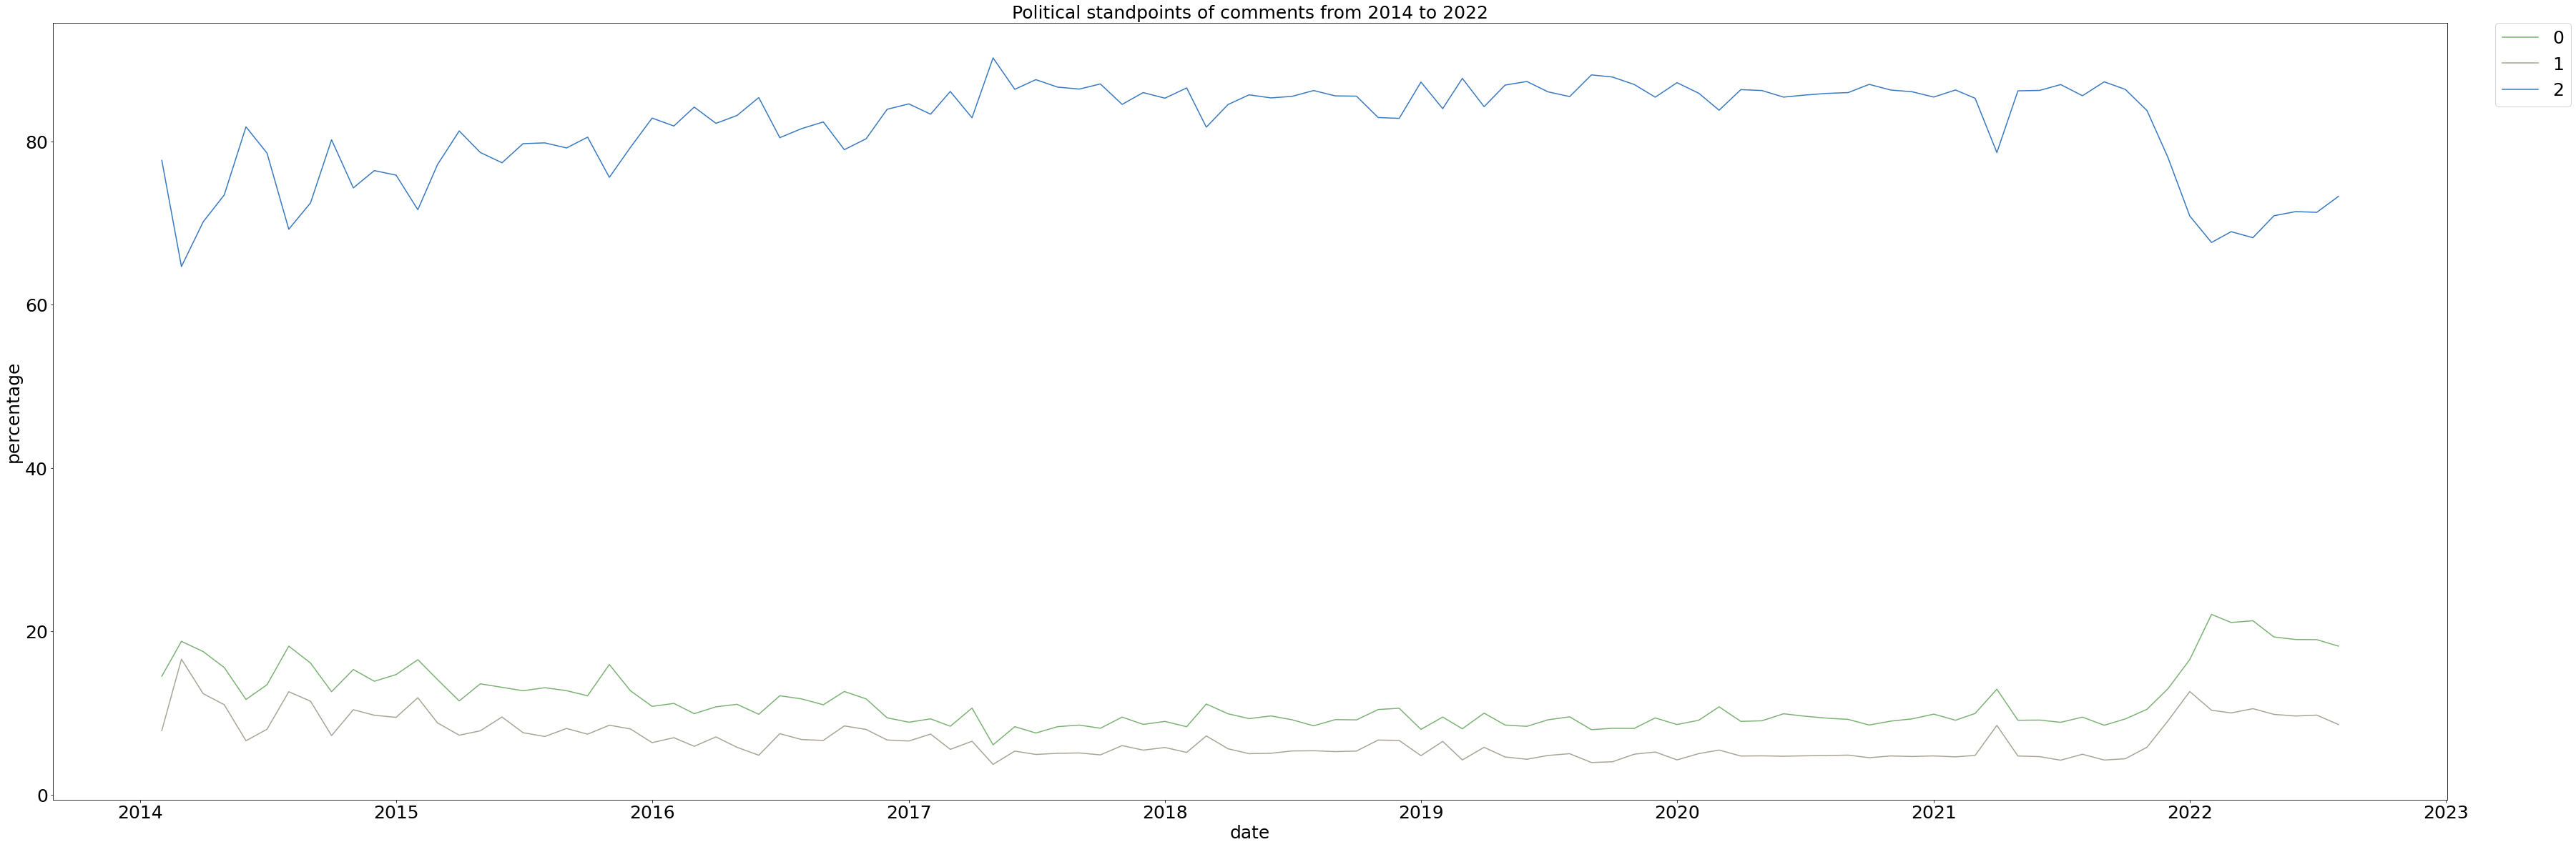

In [0]:
f, ax = plt.subplots(figsize=(60, 20))

#sns.despine(top=True, right=True, left=True, bottom=True)
#palette = sns.xkcd_palette(["windows blue", "amber", "greyish", "faded green"])
palette = sns.xkcd_palette([ "faded green","greyish","windows blue"])
#sns.lineplot(x='date', y='affcount', hue='aff', data=aff_comment_all,palette = palette)
sns.lineplot(x='date', y='ratio', hue='aff', data=aff_comment_all,palette = palette)
plt.xticks(size=25)
#plt.yticks([])

plt.yticks(size =25)
plt.xlabel('date',fontsize=25)
plt.ylabel('percentage',fontsize=25)
plt.title( 'Political standpoints of comments from 2014 to 2022',fontsize=25)
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0,fontsize=25)
#plt.title('Sentiment analysis of comments from 2014 to 2022',)
plt.show()

In [0]:
df_aff_sum=df_aff_all.groupBy('aff').agg(F.sum('affcount').alias('aff_sum'))
df_aff_sum.show()

In [0]:
def handle_submission(year_range = [2015, 2016, 2017], month_range = range(1, 13)):
    df_result = None
    for year in year_range:
        
        for month in month_range:
            
            month_literal = str(month)
            data_path = "/mnt/lsde/group05/submission_position_3class/" + str(year) + "-" + month_literal + ".parquet"
            print("start handling "+str(year) + "-" + month_literal)
            df =spark.read.load(data_path,format="parquet")
            df =df.withColumn("aff",judgeAff_f('result'))
            aff_group = df.groupBy('aff').agg(F.count('id').alias('affcount')).withColumn('date',lit(str(year) + "-" + month_literal))
            if df_result is None:
                df_result = aff_group
            else:
                df_result = df_result.union(aff_group)
            print("finish handling "+str(year) + "-" + month_literal)
    return df_result

In [0]:
df_2014_sub= handle_submission([2014],range(2,13))

start handling 2014-2
finish handling 2014-2
start handling 2014-3
finish handling 2014-3
start handling 2014-4
finish handling 2014-4
start handling 2014-5
finish handling 2014-5
start handling 2014-6
finish handling 2014-6
start handling 2014-7
finish handling 2014-7
start handling 2014-8
finish handling 2014-8
start handling 2014-9
finish handling 2014-9
start handling 2014-10
finish handling 2014-10
start handling 2014-11
finish handling 2014-11
start handling 2014-12
finish handling 2014-12

In [0]:
df_from2015_sub = handle_submission(range(2015,2022),range(1,13))

start handling 2015-1
finish handling 2015-1
start handling 2015-2
finish handling 2015-2
start handling 2015-3
finish handling 2015-3
start handling 2015-4
finish handling 2015-4
start handling 2015-5
finish handling 2015-5
start handling 2015-6
finish handling 2015-6
start handling 2015-7
finish handling 2015-7
start handling 2015-8
finish handling 2015-8
start handling 2015-9
finish handling 2015-9
start handling 2015-10
finish handling 2015-10
start handling 2015-11
finish handling 2015-11
start handling 2015-12
finish handling 2015-12
start handling 2016-1
finish handling 2016-1
start handling 2016-2
finish handling 2016-2
start handling 2016-3
finish handling 2016-3
start handling 2016-4
finish handling 2016-4
start handling 2016-5
finish handling 2016-5
start handling 2016-6
finish handling 2016-6
start handling 2016-7
finish handling 2016-7
start handling 2016-8
finish handling 2016-8
start handling 2016-9
finish handling 2016-9
start handling 2016-10
finish handling 2016-10
start handling 2016-11
finish handling 2016-11
start handling 2016-12
finish handling 2016-12
start handling 2017-1
finish handling 2017-1
start handling 2017-2
finish handling 2017-2
start handling 2017-3
finish handling 2017-3
start handling 2017-4
finish handling 2017-4
start handling 2017-5
finish handling 2017-5
start handling 2017-6
finish handling 2017-6
start handling 2017-7
finish handling 2017-7
start handling 2017-8
finish handling 2017-8
start handling 2017-9
finish handling 2017-9
start handling 2017-10
finish handling 2017-10
start handling 2017-11
finish handling 2017-11
start handling 2017-12
finish handling 2017-12
start handling 2018-1
finish handling 2018-1
start handling 2018-2
finish handling 2018-2
start handling 2018-3
finish handling 2018-3
start handling 2018-4
finish handling 2018-4
start handling 2018-5
finish handling 2018-5
start handling 2018-6
finish handling 2018-6
start handling 2018-7
finish handling 2018-7
start handling 2018-8
finish handling 2018-8
start handling 2018-9
finish handling 2018-9
start handling 2018-10
finish handling 2018-10
start handling 2018-11
finish handling 2018-11
start handling 2018-12
finish handling 2018-12
start handling 2019-1
finish handling 2019-1
start handling 2019-2
finish handling 2019-2
start handling 2019-3
finish handling 2019-3
start handling 2019-4
finish handling 2019-4
start handling 2019-5
finish handling 2019-5
start handling 2019-6
finish handling 2019-6
start handling 2019-7
finish handling 2019-7
start handling 2019-8
finish handling 2019-8
start handling 2019-9
finish handling 2019-9
start handling 2019-10
finish handling 2019-10
start handling 2019-11
finish handling 2019-11
start handling 2019-12
finish handling 2019-12
start handling 2020-1
finish handling 2020-1
start handling 2020-2
finish handling 2020-2
start handling 2020-3
finish handling 2020-3
start handling 2020-4
finish handling 2020-4
start handling 2020-5
finish handling 2020-5
start handling 2020-6
finish handling 2020-6
start handling 2020-7
finish handling 2020-7
start handling 2020-8
finish handling 2020-8
start handling 2020-9
finish handling 2020-9
start handling 2020-10
finish handling 2020-10
start handling 2020-11
finish handling 2020-11
start handling 2020-12
finish handling 2020-12
start handling 2021-1
finish handling 2021-1
start handling 2021-2
finish handling 2021-2
start handling 2021-3
finish handling 2021-3
start handling 2021-4
finish handling 2021-4
start handling 2021-5
finish handling 2021-5
start handling 2021-6
finish handling 2021-6
start handling 2021-7
finish handling 2021-7
start handling 2021-8
finish handling 2021-8
start handling 2021-9
finish handling 2021-9
start handling 2021-10
finish handling 2021-10
start handling 2021-11
finish handling 2021-11
start handling 2021-12
finish handling 2021-12

In [0]:
df_2022_sub=handle_submission([2022],range(1,9))

start handling 2022-1
finish handling 2022-1
start handling 2022-2
finish handling 2022-2
start handling 2022-3
finish handling 2022-3
start handling 2022-4
finish handling 2022-4
start handling 2022-5
finish handling 2022-5
start handling 2022-6
finish handling 2022-6
start handling 2022-7
finish handling 2022-7
start handling 2022-8
finish handling 2022-8

In [0]:
df_aff_allsub=df_2014_sub.union(df_from2015_sub).union(df_2022_sub)

In [0]:
df_aff_allsub.show()

+---+--------+------+
aff|affcount| date|
+---+--------+------+
 1| 1235|2014-2|
 2| 1575|2014-2|
 0| 4633|2014-2|
 1| 4249|2014-3|
 2| 2169|2014-3|
 0| 10802|2014-3|
 1| 1783|2014-4|
 2| 1494|2014-4|
 0| 5365|2014-4|
 1| 1393|2014-5|
 2| 1502|2014-5|
 0| 4881|2014-5|
 1| 885|2014-6|
 2| 1382|2014-6|
 0| 3467|2014-6|
 1| 2161|2014-7|
 2| 2473|2014-7|
 0| 6352|2014-7|
 1| 2500|2014-8|
 2| 1796|2014-8|
+---+--------+------+
only showing top 20 rows

In [0]:
df_aff_allsub_daysum = df_aff_allsub.groupBy('date').agg(F.sum('affcount').alias('aff-monthsum')).orderBy('date')

In [0]:
tmp = df_aff_allsub.join(df_aff_allsub_daysum,"date").select(df_aff_allsub.date,"aff","affcount","aff-monthsum")
overall_aff = tmp.withColumn('ratio',100*F.col("affcount")/F.col("aff-monthsum")).orderBy('date')
overall_aff.show()

+-------+---+--------+------------+------------------+
 date|aff|affcount|aff-monthsum| ratio|
+-------+---+--------+------------+------------------+
2014-10| 1| 1263| 7581| 16.66007123070835|
2014-10| 0| 4471| 7581| 58.97638833926923|
2014-10| 2| 1847| 7581|24.363540430022425|
2014-11| 1| 1728| 7971| 21.67858487015431|
2014-11| 0| 4439| 7971| 55.68937398067997|
2014-11| 2| 1804| 7971|22.632041149165726|
2014-12| 1| 1678| 8181|20.510939982887177|
2014-12| 2| 1884| 8181| 23.02896956362303|
2014-12| 0| 4619| 8181| 56.46009045348979|
 2014-2| 0| 4633| 7443| 62.24640601907833|
 2014-2| 1| 1235| 7443|16.592771731828563|
 2014-2| 2| 1575| 7443| 21.16082224909311|
 2014-3| 1| 4249| 17220| 24.67479674796748|
 2014-3| 0| 10802| 17220| 62.72938443670151|
 2014-3| 2| 2169| 17220|12.595818815331011|
 2014-4| 1| 1783| 8642|20.631798194862302|
 2014-4| 0| 5365| 8642|62.080536912751676|
 2014-4| 2| 1494| 8642|17.287664892386022|
 2014-5| 2| 1502| 7776| 19.31584362139918|
 2014-5| 1| 1393| 7776| 17.91409465020576|
+-------+---+--------+------------+------------------+
only showing top 20 rows

In [0]:
allsub_pd=overall_aff.toPandas()

In [0]:
allsub_pd.head()

Out[73]:

,date,aff,affcount,aff-monthsum,ratio,newdate
11,2014-02-01,0,4633,7443,62.246406,2014-02
9,2014-02-01,1,1235,7443,16.592772,2014-02
10,2014-02-01,2,1575,7443,21.160822,2014-02
14,2014-03-01,0,10802,17220,62.729384,2014-03
13,2014-03-01,2,2169,17220,12.595819,2014-03


In [0]:
allsub_pd['newdate'] = allsub_pd['date'].apply(handledate)
allsub_pd['date'] = pd.to_datetime(allsub_pd['newdate'])


In [0]:
allsub_pd = allsub_pd.sort_values('date')

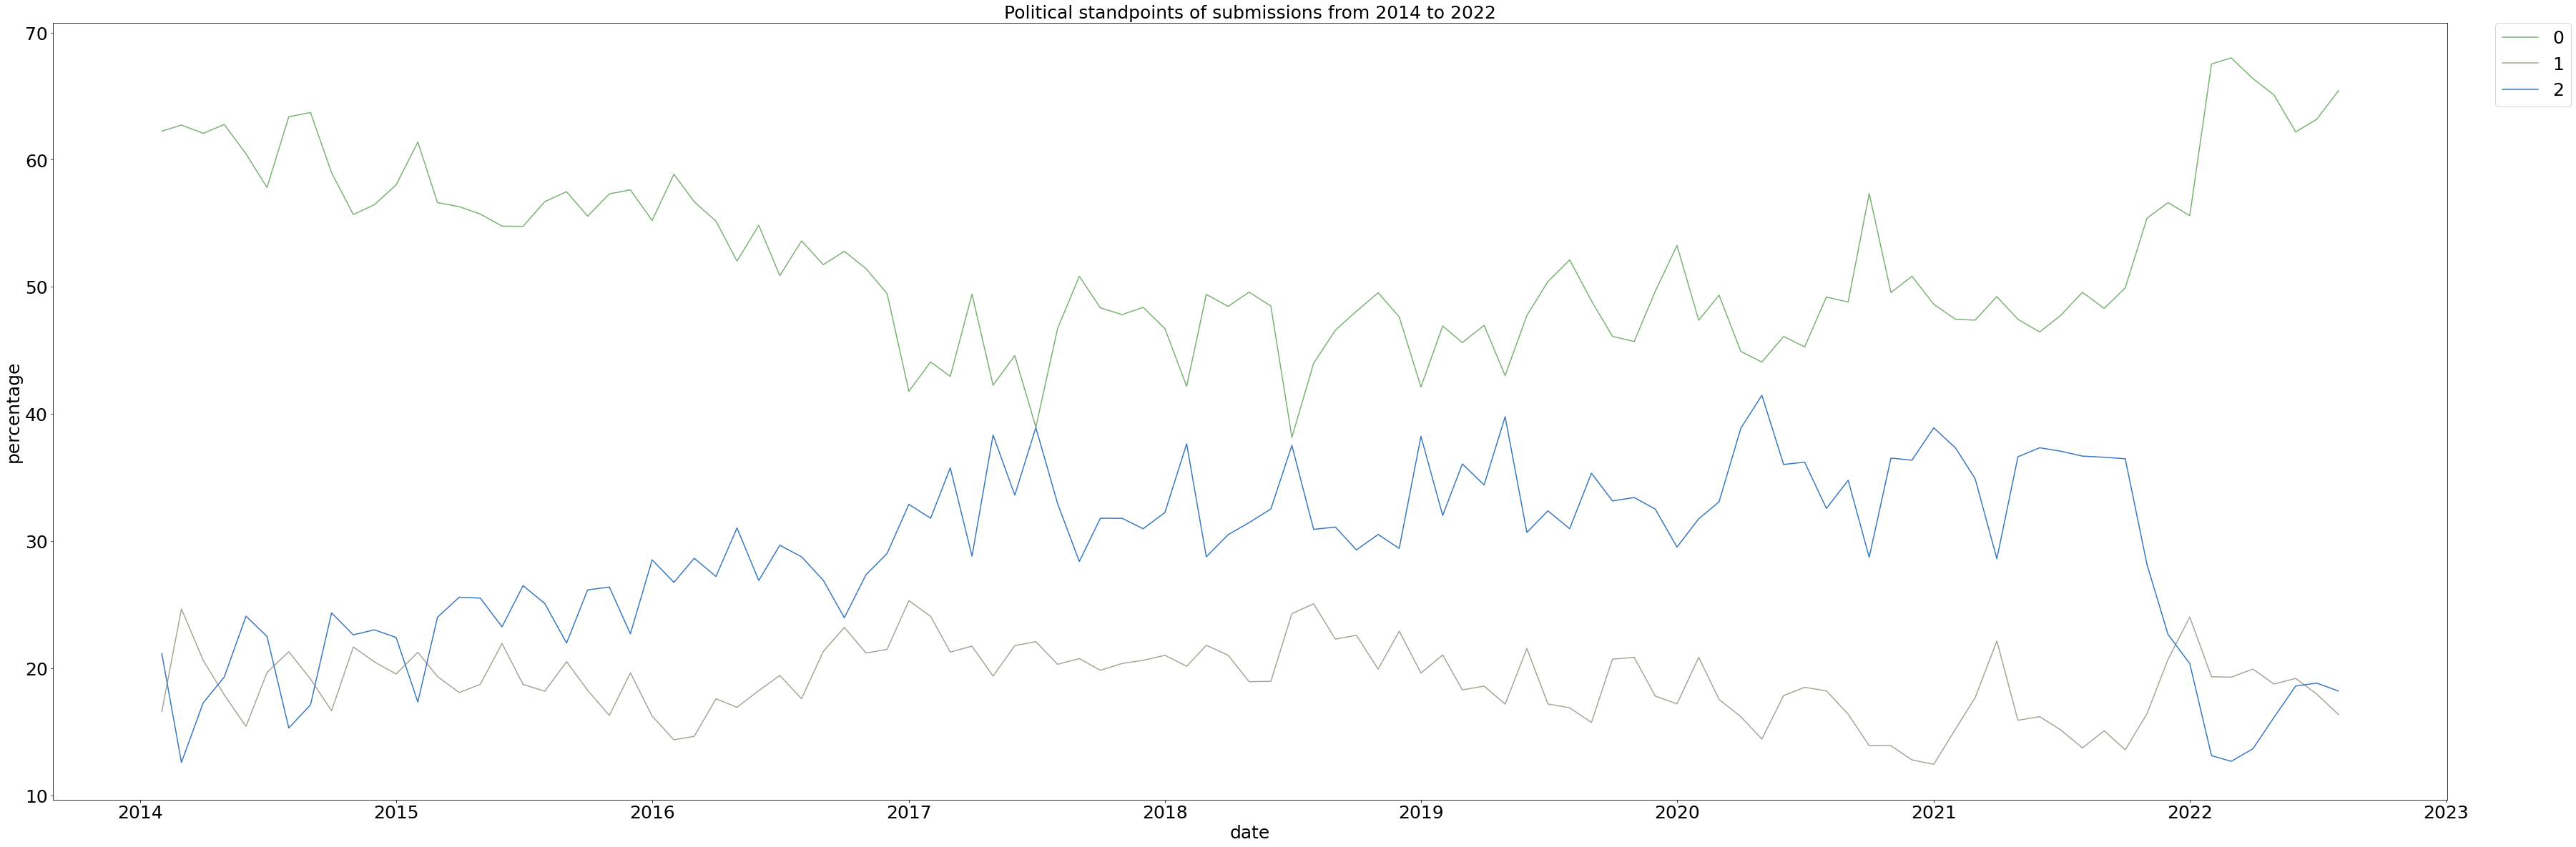

In [0]:
f, ax = plt.subplots(figsize=(60, 20))

#sns.despine(top=True, right=True, left=True, bottom=True)
#palette = sns.xkcd_palette(["windows blue", "amber", "greyish", "faded green"])
palette = sns.xkcd_palette([ "faded green","greyish","windows blue"])
sns.lineplot(x='date', y='ratio', hue='aff', data=allsub_pd,palette = palette)
#plt.xticks([])
#plt.yticks([])
plt.xticks(size=25)
plt.yticks(size =25)
plt.xlabel('date',fontsize=25)
plt.ylabel('percentage',fontsize=25)
plt.title( 'Political standpoints of submissions from 2014 to 2022',fontsize=25)
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0,fontsize=25)
#plt.title('Sentiment analysis of comments from 2014 to 2022',)
plt.show()

In [0]:
df_aff_sumsub=df_aff_allsub.groupBy('aff').agg(F.sum('affcount').alias('aff_sum'))
df_aff_sumsub.show()

+---+-------+
aff|aff_sum|
+---+-------+
 1| 457318|
 2| 619052|
 0|1297150|
+---+-------+